In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from bycycle.filt import lowpass_filter, bandpass_filter
from bycycle.features import compute_features
import pandas as pd
import seaborn as sns
pd.options.display.max_columns=50
import mne 

### load ECOG data patient sub000

In [2]:
dat = mne.io.read_raw_brainvision("C:\\Users\\ICN_admin\\Documents\\BIDS\\sub-000\\ses-right\\eeg\\sub-000_ses-right_task-force_run-0_eeg.vhdr")

Extracting parameters from C:\Users\ICN_admin\Documents\BIDS\sub-000\ses-right\eeg\sub-000_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...


In [3]:
dat.ch_names

['ECOG_RIGHT_0',
 'ECOG_RIGHT_1',
 'ECOG_RIGHT_2',
 'ECOG_RIGHT_3',
 'ECOG_RIGHT_4',
 'ECOG_RIGHT_5',
 'MOV_RIGHT',
 'MOV_LEFT']

In [4]:
time_ = np.arange(0,dat.get_data().shape[1], 1)*0.001

Text(0.5, 1.0, 'movement left and right')

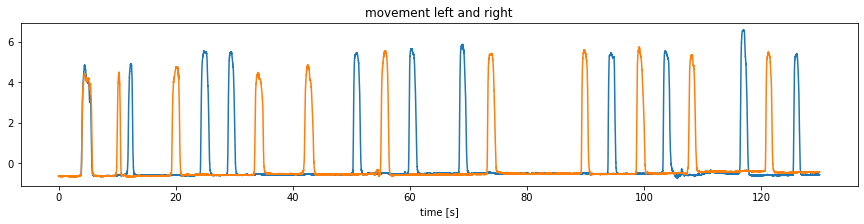

In [5]:
plt.figure(figsize=(15,3))
plt.plot(time_, dat.get_data()[[6,7]].T)
plt.xlabel('time [s]')
plt.title('movement left and right')

### extract movement / no movement segements

#### for movement concatenate when label>0 and it is not in a margin around detected movements

In [11]:
def get_dat_no_mov(mov_dat, ch_dat, margin = 1):
    idx_mov = []; idx_no_mov = []
    arr_boool = np.array(mov_dat>1).astype(int)
    for idx, i in enumerate(np.arange(margin, arr_boool.shape[0] - margin, 1)):
        if arr_boool[i] > 0:
            idx_mov.append(i)
            continue
        if np.sum(arr_boool[i-margin:i]) > 0:
            idx_mov.append(i)
            continue
        if np.sum(arr_boool[i:i+margin]) > 0:
            idx_mov.append(i)
            continue
        idx_no_mov.append(i)
    return mov_dat[idx_mov], ch_dat[idx_mov], mov_dat[idx_no_mov], ch_dat[idx_no_mov], idx_mov, idx_no_mov

In [12]:
# extract contralateral movement segments 
label_mov, dat_mov, label_no_mov, dat_no_mov, idx_mov, idx_no_mov = get_dat_no_mov(dat.get_data()[7], dat.get_data()[[0,1,2,3,4,5]].T)

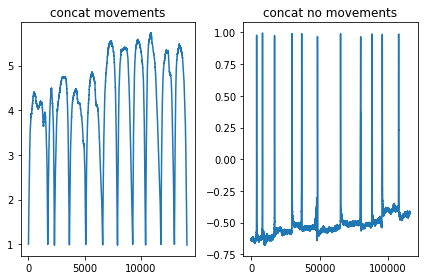

In [13]:
plt.subplot(121)
plt.plot(label_mov)
plt.title("concat movements")
plt.subplot(122)
plt.plot(label_no_mov)
plt.title("concat no movements")
plt.tight_layout()

In [14]:
dat_mov.shape

(14116, 6)

In [15]:
dat_no_mov.shape

(115883, 6)

#### for the sake of this analysis, concatenate both time segements
#### and use both length for both

In [38]:
x = np.concatenate((dat_mov, dat_no_mov[:14116,:]), axis=1)

In [39]:
x.shape

(14116, 12)

### Usage of Bycycle toolbox

In [40]:
signals = list(x.T)

In [41]:
len(signals)

12

In [42]:
signals = stats.zscore(signals)

In [43]:
Fs = 1000
# Apply lowpass filter to each signal
for i in range(len(signals)):
    signals[i] = lowpass_filter(signals[i], Fs, 80, N_seconds=.2, remove_edge_artifacts=False)
    #signals[i] = bandpass_filter(signals[i], Fs, (5,30), N_seconds=.2, remove_edge_artifacts=False)

### Plot for patient 0 for all channel the whole mov / no mov time course

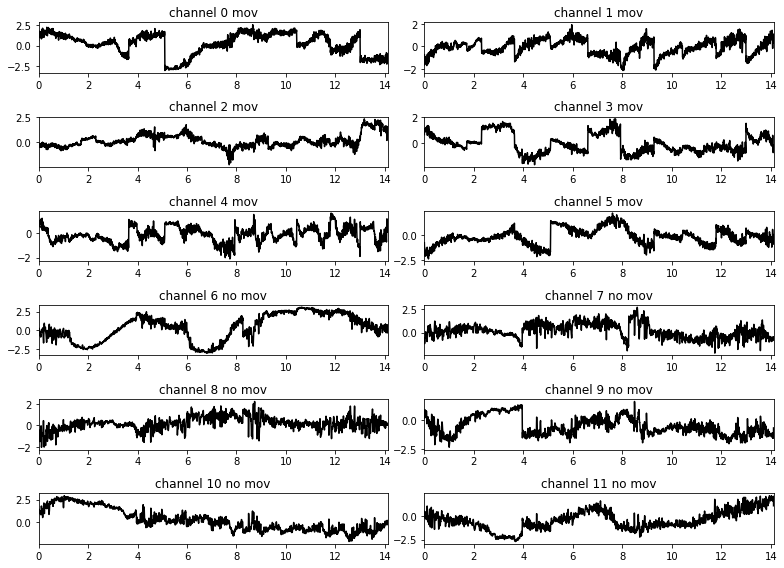

In [44]:
N = len(signals)
T = len(signals[0])/Fs
t = np.arange(0, T, 1/Fs)

plt.figure(figsize=(11,8))
for i in range(12):
    plt.subplot(6,2,i+1)
    plt.plot(t, signals[i], 'k')
    plt.xlim((0, T))
    if i<6:
        plt.title('channel '+str(i)+' mov')
    else:
        plt.title('channel '+str(i)+' no mov')
plt.tight_layout()
plt.show()

In [45]:
t.shape

(14116,)

### plot time course for only 1 second

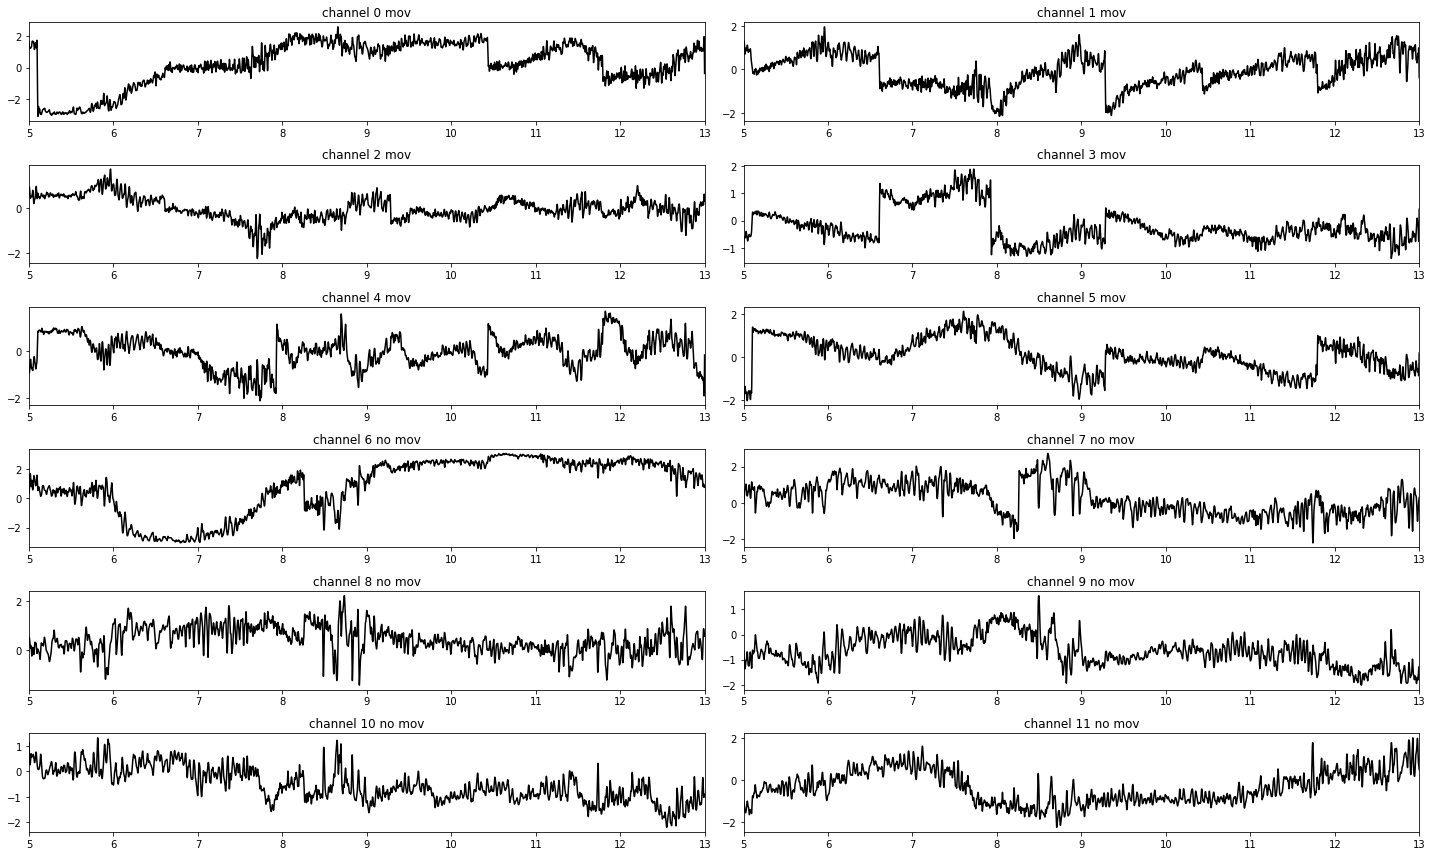

In [50]:
N = len(signals)
T = len(signals[0])/Fs
t = np.arange(0, T, 1/Fs)

plt.figure(figsize=(20,12))
for i in range(12):
    plt.subplot(6,2,i+1)
    plt.plot(t[5000:13000], signals[i][5000:13000], 'k')
    plt.xlim((5, 13))# 0,T
    if i<6:
        plt.title('channel '+str(i)+' mov')
    else:
        plt.title('channel '+str(i)+' no mov')
plt.tight_layout()
plt.show()

well there seems to be a high LPF component

### Compute Cycle by cycle features

In [51]:
f_alpha = (7, 13) # Frequency band of interest
burst_kwargs = {'amplitude_fraction_threshold': .2,
                'amplitude_consistency_threshold': .2,
                'period_consistency_threshold': .5,
                'monotonicity_threshold': .8,
                'N_cycles_min': 3} # Tuned burst detection parameters

# Compute features for each signal and concatenate into single dataframe
dfs = []
for i in range(N):
    df = compute_features(signals[i], Fs, f_alpha,
                          burst_detection_kwargs=burst_kwargs)
    if i >= 6:
        df['group'] = 'no_mov'
    else:
        df['group'] = 'mov'
    df['ch_id'] = i
    dfs.append(df)
df_cycles = pd.concat(dfs)

C:\Users\ICN_admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ICN_admin\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [294]:
compute_features?

In [52]:
print(df_cycles.head())

   sample_peak  sample_zerox_decay  sample_zerox_rise  sample_last_trough  \
0          253                 262                227                 215   
1          314                 334                285                 280   
2          393                 406                363                 356   
3          460                 506                441                 435   
4          576                 599                561                 547   

   sample_next_trough  period  time_peak  time_trough  volt_peak  volt_trough  \
0                 280      65         35           45   1.911220     1.005500   
1                 356      76         49           23   1.862356     1.345470   
2                 435      79         43           29   2.229537     1.208803   
3                 547     112         65           35   1.974280     1.502108   
4                 644      97         38           55   2.101398     1.333826   

   time_decay  time_rise  volt_decay  volt_rise  v

### Confirm appropriateness of burst detection parameters

From the tutorial:
##### These burst detection parameters seem appropriate because they mostly restrict the analysis to periods of the signal that appear to be bursting. This was confirmed by looking at a few different signal segments from a few subjects.

[<Figure size 2160x1080 with 5 Axes>,

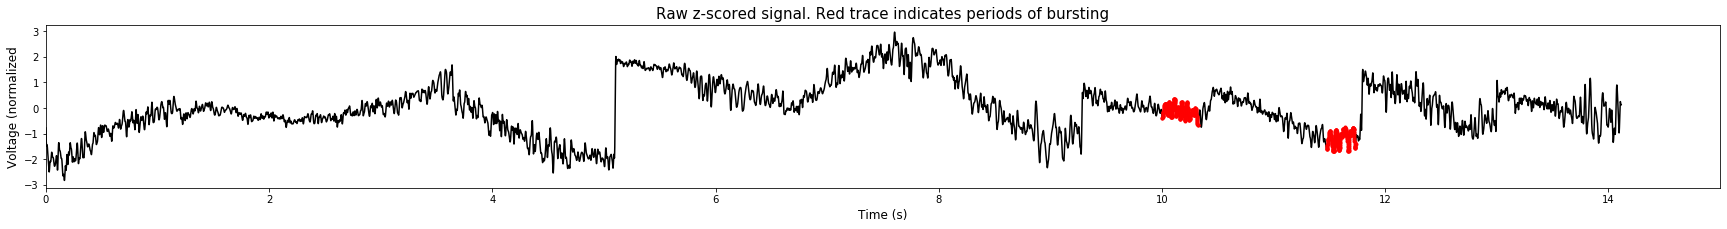

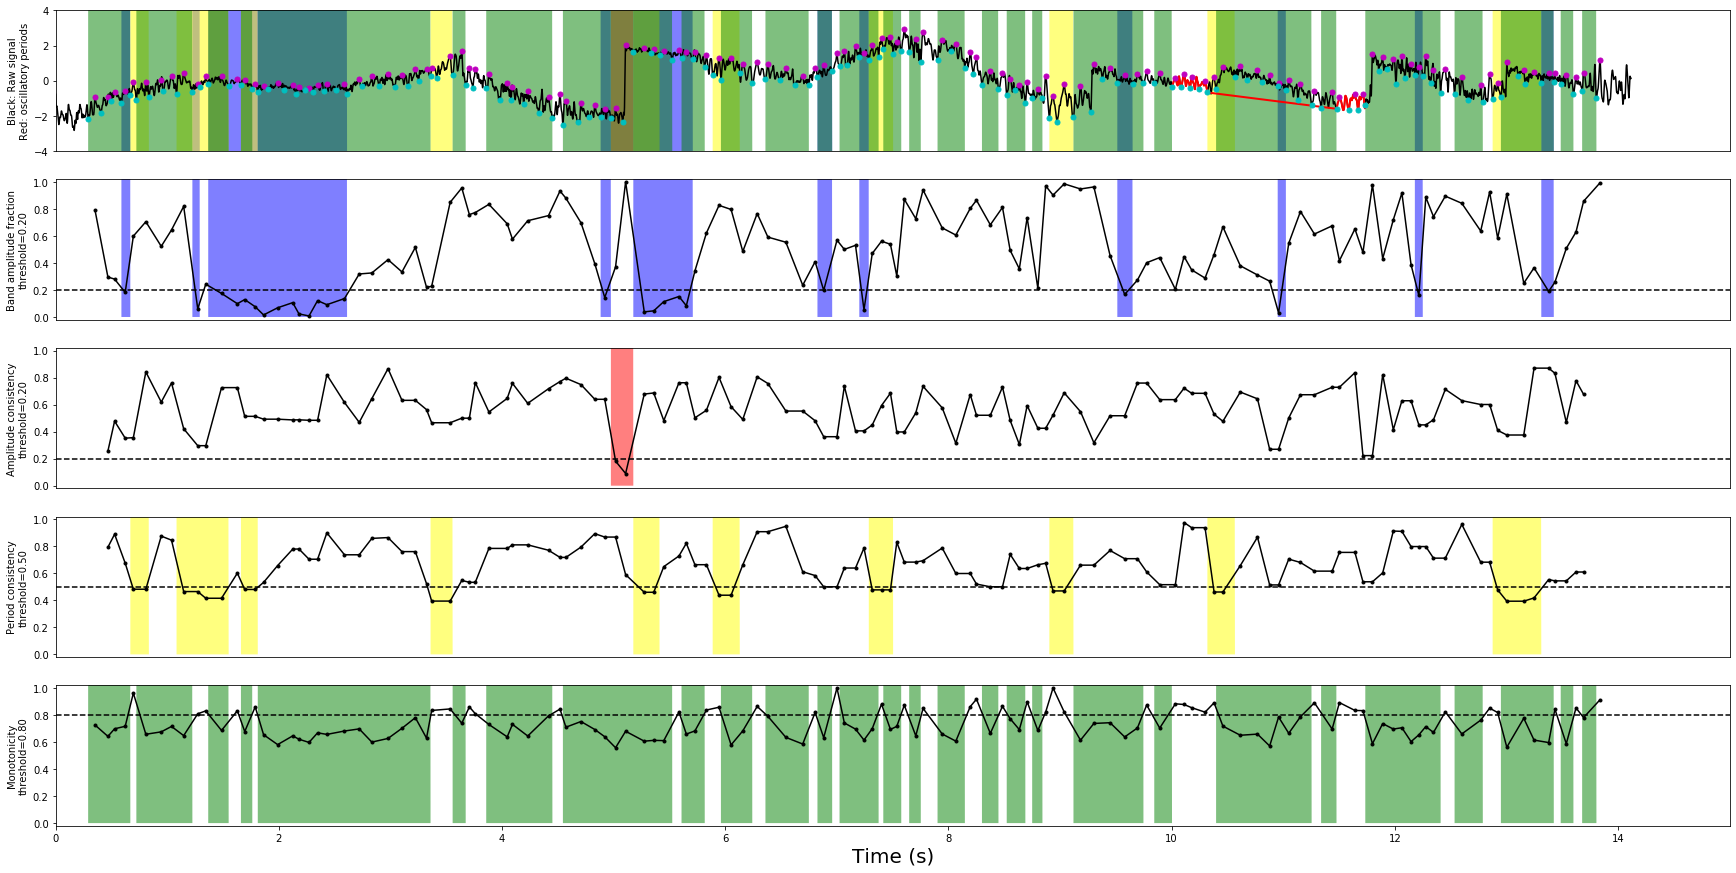

In [56]:
ch =5
signal_df = df_cycles[df_cycles['ch_id']==ch]
from bycycle.burst import plot_burst_detect_params
plot_burst_detect_params(signals[ch], Fs, signal_df,
                         burst_kwargs, tlims=(0, 15), figsize=(30, 3), plot_only_result=True)

plot_burst_detect_params(signals[ch], Fs, signal_df,
                         burst_kwargs, tlims=(0, 15), figsize=(30, 3))

#### Analyze cycle-by-cycle features

In [57]:
# Only consider cycles that were identified to be in bursting regimes

#df_cycles_burst = df_cycles[df_cycles['is_burst']]
df_cycles_burst = df_cycles#[df_cycles['is_burst']]
# Compute average features across subjects in a recording
features_keep = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']
df_movement_analysis = df_cycles_burst.groupby(['group', 'ch_id']).mean()[features_keep].reset_index()
print(df_movement_analysis)

     group  ch_id  volt_amp      period  time_rdsym  time_ptsym
0      mov      0  0.765738   97.664286    0.535856    0.498563
1      mov      1  0.705364  106.637795    0.574946    0.502415
2      mov      2  0.554892  102.171642    0.506549    0.498203
3      mov      3  0.506123  101.210526    0.461475    0.505105
4      mov      4  0.674864  103.702290    0.472560    0.500325
5      mov      5  0.661891  103.196970    0.480219    0.506356
6   no_mov      6  0.845721   97.835714    0.489686    0.542550
7   no_mov      7  1.131591   99.398551    0.527927    0.570809
8   no_mov      8  1.006059  104.183206    0.535717    0.562734
9   no_mov      9  0.789884   98.318841    0.464858    0.482870
10  no_mov     10  0.810555  101.681481    0.473940    0.444165
11  no_mov     11  0.919099  101.820896    0.481278    0.454325


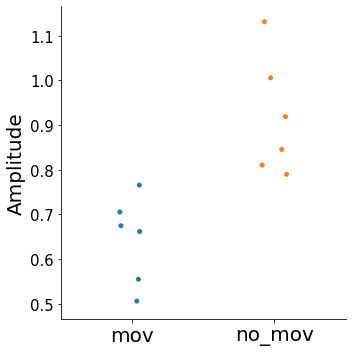

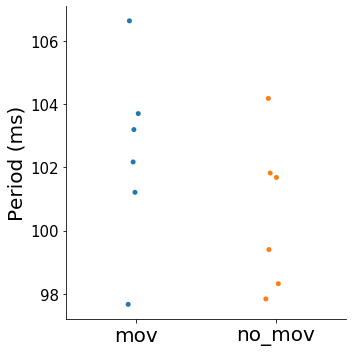

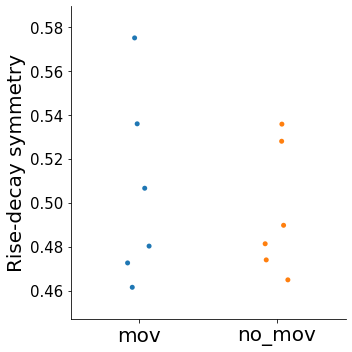

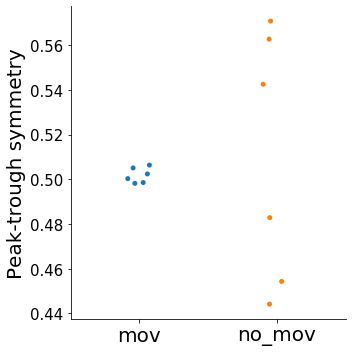

In [58]:
feature_names = {'volt_amp': 'Amplitude',
                 'period': 'Period (ms)',
                 'time_rdsym': 'Rise-decay symmetry',
                 'time_ptsym': 'Peak-trough symmetry'}
for feat, feat_name in feature_names.items():
    g = sns.catplot(x='group', y=feat, data=df_movement_analysis)
    plt.xlabel('')
    plt.xticks(size=20)
    plt.ylabel(feat_name, size=20)
    plt.yticks(size=15)
    plt.tight_layout()
    plt.show()

In [59]:
df_mov = df_cycles_burst[df_cycles_burst["group"].str.contains("mov")]
df_no_mov = df_cycles_burst[df_cycles_burst["group"].str.contains("no_mov")]

In [60]:
df_mov

,sample_peak,sample_zerox_decay,sample_zerox_rise,sample_last_trough,sample_next_trough,period,time_peak,time_trough,volt_peak,volt_trough,time_decay,time_rise,volt_decay,volt_rise,volt_amp,time_rdsym,time_ptsym,band_amp,amp_fraction,amp_consistency,period_consistency,monotonicity,is_burst,group,ch_id
0,253,262,227,215,280,65,35,45,1.911220,1.005500,27,38,0.565750,0.905720,0.735735,0.584615,0.437500,0.120466,0.550000,NaN,NaN,0.766632,False,mov,0
1,314,334,285,280,356,76,49,23,1.862356,1.345470,42,34,0.653553,0.516886,0.585219,0.447368,0.680556,0.040419,0.371429,0.640277,0.855263,0.693274,False,mov,0
2,393,406,363,356,435,79,43,29,2.229537,1.208803,42,37,0.727429,1.020734,0.874081,0.468354,0.597222,0.095369,0.714286,0.640277,0.705357,0.700881,False,mov,0
3,460,506,441,435,547,112,65,35,1.974280,1.502108,87,25,0.640454,0.472172,0.556313,0.223214,0.650000,0.121224,0.328571,0.649097,0.705357,0.692345,False,mov,0
4,576,599,561,547,644,97,38,55,2.101398,1.333826,68,29,0.867232,0.767571,0.817402,0.298969,0.408602,0.146735,0.650000,0.521149,0.546392,0.843284,False,mov,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,13507,13529,13497,13488,13547,59,32,45,1.626129,0.269856,40,19,0.805826,1.356273,1.081050,0.322034,0.415584,0.204001,0.694030,0.594147,0.468254,0.897436,False,no_mov,11
130,13579,13597,13571,13547,13658,111,26,42,2.125366,0.820303,79,32,1.599756,1.305063,1.452409,0.288288,0.382353,0.318169,0.880597,0.617461,0.531532,0.778122,False,no_mov,11
131,13683,13695,13671,13658,13731,73,24,74,1.830790,0.525611,48,25,0.763950,1.305179,1.034564,0.342466,0.244898,0.236347,0.649254,0.585322,0.657658,0.882979,False,no_mov,11
132,13755,13791,13739,13731,13825,94,52,44,1.825383,1.066840,70,24,1.129393,0.758543,0.943968,0.255319,0.541667,0.082436,0.574627,0.671638,0.638298,0.862319,False,no_mov,11


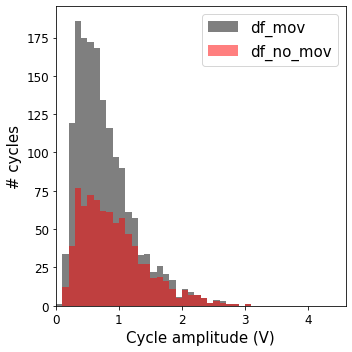

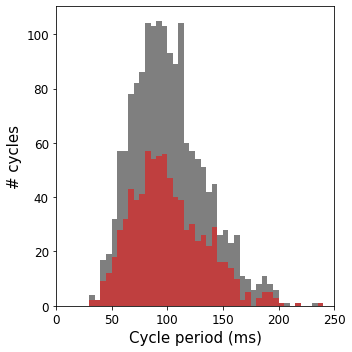

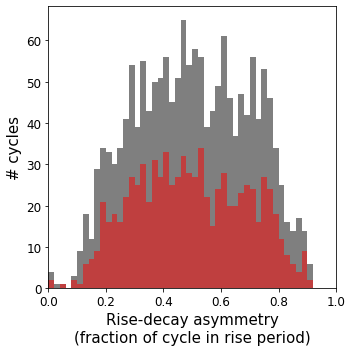

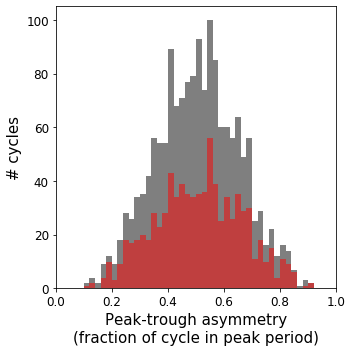

In [61]:
plt.figure(figsize=(5, 5))
plt.hist(df_mov['volt_amp'], bins=np.arange(0, 8, .1), color='k', alpha=.5, label='df_mov')
plt.hist(df_no_mov['volt_amp'], bins=np.arange(0, 8, .1), color='r', alpha=.5, label='df_no_mov')
plt.xticks(np.arange(5), size=12)
plt.legend(fontsize=15)
plt.yticks(size=12)
plt.xlim((0, 4.6))
plt.xlabel('Cycle amplitude (V)', size=15)
plt.ylabel('# cycles', size=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.hist(df_mov['period'] / Fs * 1000, bins=np.arange(0, 250, 5), color='k', alpha=.5)
plt.hist(df_no_mov['period'] / Fs * 1000, bins=np.arange(0, 250, 5), color='r', alpha=.5)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim((0, 250))
plt.xlabel('Cycle period (ms)', size=15)
plt.ylabel('# cycles', size=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.hist(df_mov['time_rdsym'], bins=np.arange(0, 1, .02), color='k', alpha=.5)
plt.hist(df_no_mov['time_rdsym'], bins=np.arange(0, 1, .02), color='r', alpha=.5)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim((0, 1))
plt.xlabel('Rise-decay asymmetry\n(fraction of cycle in rise period)', size=15)
plt.ylabel('# cycles', size=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.hist(df_mov['time_ptsym'], bins=np.arange(0, 1, .02), color='k', alpha=.5)
plt.hist(df_no_mov['time_ptsym'], bins=np.arange(0, 1, .02), color='r', alpha=.5)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim((0, 1))
plt.xlabel('Peak-trough asymmetry\n(fraction of cycle in peak period)', size=15)
plt.ylabel('# cycles', size=15)
plt.tight_layout()
plt.show()

### verify beta-gamma PAC for ECOG

In [305]:
from tensorpac import Pac
from tensorpac.signals import pac_signals_tort

In [342]:
# Define a Pac object
p = Pac(idpac=(5, 0, 0), f_pha='hres', f_amp='hres')
# Filter the data and extract pac
xpac = p.filterfit(Fs, dat.get_data()[0,:])

Phase Amplitude Coupling object defined
    Extract phases (n_pha=54) and amplitudes (n_amps=48)
    true PAC estimation using Phase-Synchrony (Cohen et al. 2008; Penny et al. 2008)


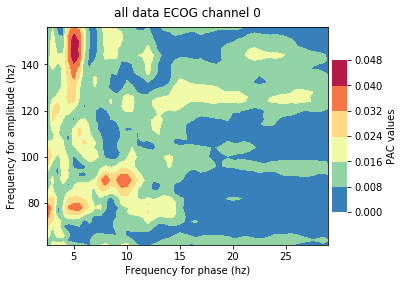

In [343]:
p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title=r'all data ECOG channel 0')
p.show()

### channel 1

In [337]:
Pac?

Phase Amplitude Coupling object defined
    Extract phases (n_pha=54) and amplitudes (n_amps=48)
    true PAC estimation using Phase-Synchrony (Cohen et al. 2008; Penny et al. 2008)


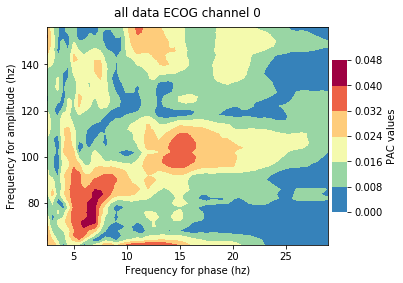

In [344]:
# Define a Pac object
p = Pac(idpac=(5, 0, 0), f_pha='hres', f_amp='hres')
# Filter the data and extract pac
xpac = p.filterfit(Fs, dat.get_data()[1,:])
p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title=r'all data ECOG channel 0')
p.show()

### channel 2

Phase Amplitude Coupling object defined
    Extract phases (n_pha=54) and amplitudes (n_amps=48)
    true PAC estimation using Phase-Synchrony (Cohen et al. 2008; Penny et al. 2008)


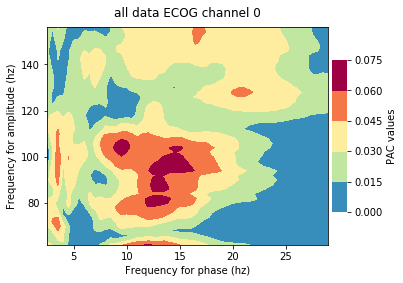

In [341]:
# Define a Pac object
p = Pac(idpac=(5, 0, 0), f_pha='hres', f_amp='hres')
# Filter the data and extract pac
xpac = p.filterfit(Fs, dat.get_data()[2,:])
p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title=r'all data ECOG channel 0')
p.show()

### channel 3

In [345]:
# Define a Pac object
p = Pac(idpac=(5, 0, 0), f_pha='hres', f_amp='hres')
# Filter the data and extract pac
xpac = p.filterfit(Fs, dat.get_data()[3,:])

Phase Amplitude Coupling object defined
    Extract phases (n_pha=54) and amplitudes (n_amps=48)
    true PAC estimation using Phase-Synchrony (Cohen et al. 2008; Penny et al. 2008)


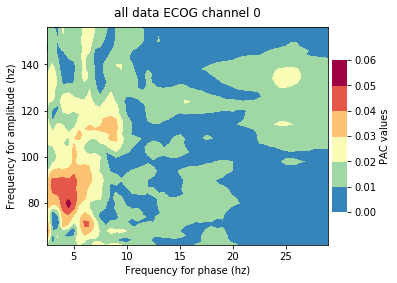

In [346]:
p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title=r'all data ECOG channel 0')
p.show()

### channel 5

Phase Amplitude Coupling object defined
    Extract phases (n_pha=54) and amplitudes (n_amps=48)
    true PAC estimation using Phase-Synchrony (Cohen et al. 2008; Penny et al. 2008)


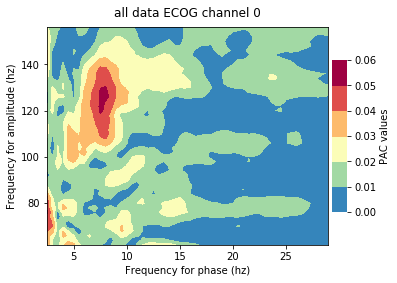

In [347]:
# Define a Pac object
p = Pac(idpac=(5, 0, 0), f_pha='hres', f_amp='hres')
# Filter the data and extract pac
xpac = p.filterfit(Fs, dat.get_data()[5,:])
p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title=r'all data ECOG channel 0')
p.show()

### no movement

Phase Amplitude Coupling object defined
    Extract phases (n_pha=54) and amplitudes (n_amps=48)
    true PAC estimation using Phase-Synchrony (Cohen et al. 2008; Penny et al. 2008)


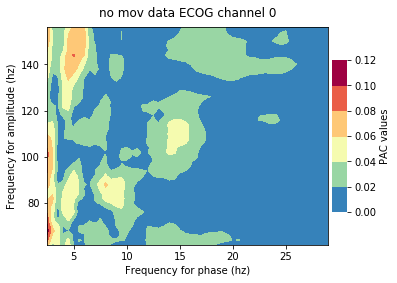

In [348]:
# Define a Pac object
p = Pac(idpac=(5, 0, 0), f_pha='hres', f_amp='hres')
# Filter the data and extract pac
xpac = p.filterfit(Fs, dat_mov[:,0])
p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title=r'no mov data ECOG channel 0')
p.show()

### movement

Phase Amplitude Coupling object defined
    Extract phases (n_pha=54) and amplitudes (n_amps=48)
    true PAC estimation using Phase-Synchrony (Cohen et al. 2008; Penny et al. 2008)


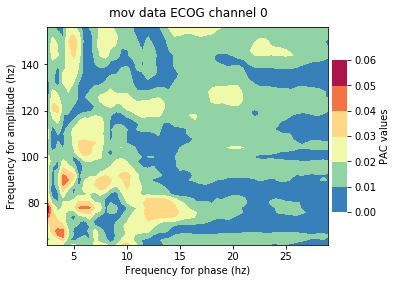

In [353]:
# Define a Pac object
p = Pac(idpac=(5, 0, 0), f_pha='hres', f_amp='hres')
# Filter the data and extract pac
xpac = p.filterfit(Fs, dat_no_mov[:,0])
p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title=r'mov data ECOG channel 0')
p.show()

Channel 0 might not lie over Sensorimotor Area? 